In [63]:
using PyPlot, Seaborn
using DataFrames
using HistogramBinnings
using StatsBase
using ForwardDiff
using Serialization

using Revise
using Simulations
using EpochModel

using NestedSamplers, Random, Distributions, AbstractMCMC, LinearAlgebra, Turing

using ProgressMeter

include("utils.jl")

setXrange (generic function with 2 methods)

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["font.serif"] = "Palatino"
rcParams["font.sans-serif"] = "Trebuchet MS"
rcParams["font.weight"] = "bold"
rcParams["axes.titleweight"] = "bold"
rcParams["axes.labelweight"] = "bold"

"bold"

In [137]:
ρ = 1e-7
TN = [271_000_000, 1119, 131, 189, 69, 1058] # following tuscan NA20532
# TN = [282_000_000, 1134, 101, 164, 82, 800, 7, 156] # following telugu HG04211
# TN = [250_000_000, 1000]
ζ = 4*ρ*TN[2]

0.0004476

In [99]:
ibd = @showprogress map(1:10) do i
    simulate(TN, ρ)
end

Progress: 100%|█████████████████████████████████████████| Time: 1:09:15


10-element Vector{Simulations.Segments{Int32, Int32, Int32}}:
 91802 segments (type:IBD, total length:271000000)
 88373 segments (type:IBD, total length:271000000)
 91485 segments (type:IBD, total length:271000000)
 93095 segments (type:IBD, total length:271000000)
 95887 segments (type:IBD, total length:271000000)
 94470 segments (type:IBD, total length:271000000)
 93867 segments (type:IBD, total length:271000000)
 96195 segments (type:IBD, total length:271000000)
 92164 segments (type:IBD, total length:271000000)
 92039 segments (type:IBD, total length:271000000)

In [100]:
# serialize("ibd_tuscan", ibd);

In [6]:
# ibs = deserialize("ibs.tuscan");
# ibs = deserialize("ibs.telugu");
ibd = deserialize("hotspots_9505");

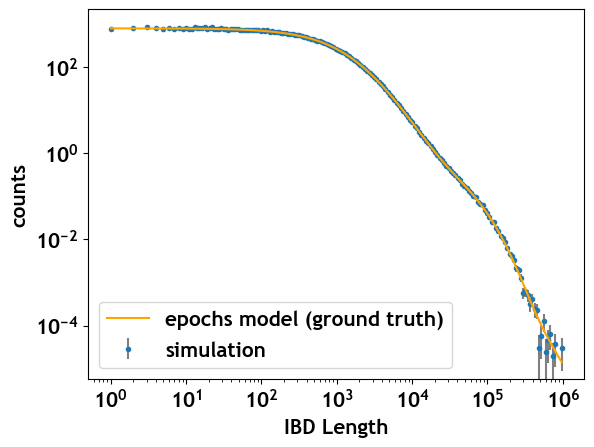

PyObject <matplotlib.legend.Legend object at 0x37afb00a0>

In [103]:
h = HistogramBinnings.Histogram(LogEdgeVector(lo = 1, hi = 1_000_000, nbins = 200))
for i in ibd
    append!(h, i.lengths)
end
xk, yk = xy(h)
widths = h.edges[1][2:end] - h.edges[1][1:end-1]
errk = sqrt.(yk .* widths) ./ widths
errorbar(xk,yk,errk,fmt="o",markersize=3,ecolor="grey",label="simulation")

yk_th = map(xk) do r 
    hid(TN, ρ, r) * length(ibd)
end
plot(xk, yk_th, color="orange",label="epochs model (ground truth)", zorder=3)

xscale("log")
yscale("log")
xlabel("IBD Length")
ylabel("counts")
legend()

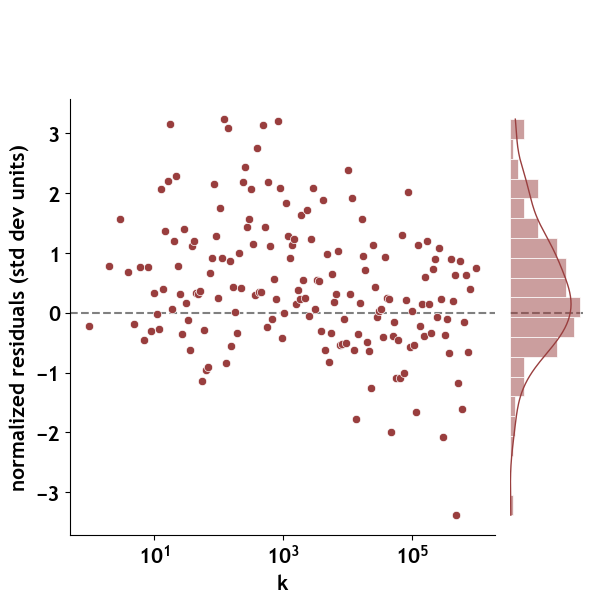

PyObject Bbox([[0.0, 0.0], [1.0, 1.0]])

In [104]:
countsk_th = map(h.edges[1][1:end-1],h.edges[1][2:end]) do r1,r2
    (EpochModel.hid_integral(TN,ρ,r2) - EpochModel.hid_integral(TN,ρ,r1) ) * length(ibd)
end;
res = (h.weights .- countsk_th) ./ sqrt.(h.weights)
xk_ = xk[(yk .!= 0)]
yk_ = res[(yk .!= 0)]

j = JointGrid()
j.refline(y=0, color="grey", linestyle="--")
scatterplot(x=xk_, y=yk_, color=(154/256,62/256,62/256), ax=j.ax_joint, zorder=2)
histplot(y=yk_, color=(154/256,62/256,62/256), edgecolor="white", linewidth=0.5, alpha=0.5, ax=j.ax_marg_y, bins=20, zorder=3, kde=true, 
    line_kws=Dict("linewidth"=>1,"zorder"=>4))
j.ax_joint.set_xscale("log")
j.ax_joint.set_xlabel("k")
j.ax_joint.set_ylabel("normalized residuals (std dev units)")
j.ax_marg_x.axis("off")
j.ax_marg_y.axis("off")
matplotlib.transforms.Bbox.from_bounds(0, 0, 1, 1)

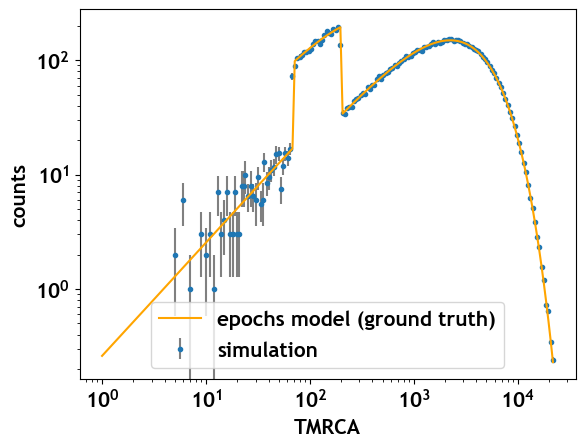

PyObject <matplotlib.legend.Legend object at 0x19e65db10>

In [105]:
h1 = HistogramBinnings.Histogram(LogEdgeVector(lo = 1, hi = 20*TN[2], nbins = 200))
for i in ibd
    append!(h1, i.times)
end
xt, yt = xy(h1)
widths = h1.edges[1][2:end] - h1.edges[1][1:end-1]
errt = sqrt.(yt .* widths) ./ widths
errorbar(xt,yt,errt,fmt="o",markersize=3,ecolor="grey",label="simulation")

yt_th = map(xt) do t 
    tmrca(t, TN, ρ) * length(ibd)
end
plot(xt, yt_th, color="orange",label="epochs model (ground truth)", zorder=3)

xscale("log")
yscale("log")
xlabel("TMRCA")
ylabel("counts")
legend()

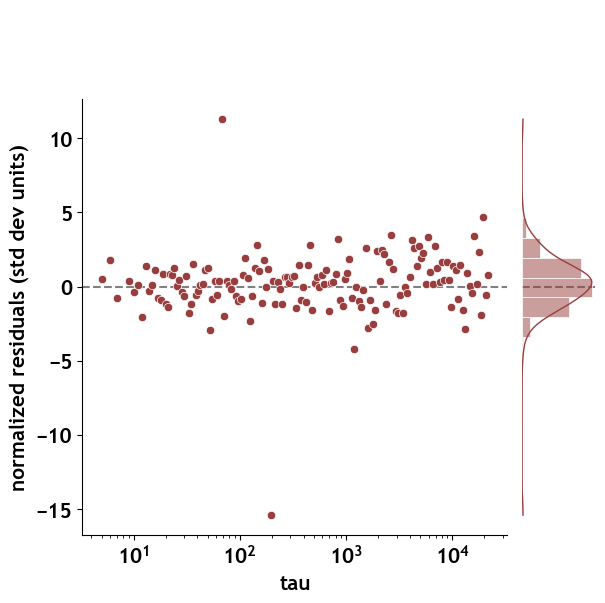

PyObject Bbox([[0.0, 0.0], [1.0, 1.0]])

In [106]:
countst_th = yt_th .* widths
res = (h1.weights .- countst_th) ./ sqrt.(h1.weights)
xt_ = xt[(yt .!= 0)]
yt_ = res[(yt .!= 0)]

j = JointGrid()
j.refline(y=0, color="grey", linestyle="--")
scatterplot(x=xt_, y=yt_, color=(154/256,62/256,62/256), ax=j.ax_joint, zorder=2)
histplot(y=yt_, color=(154/256,62/256,62/256), edgecolor="white", linewidth=0.5, alpha=0.5, ax=j.ax_marg_y, bins=20, zorder=3, kde=true, 
    line_kws=Dict("linewidth"=>1,"zorder"=>4))
j.ax_joint.set_xscale("log")
j.ax_joint.set_xlabel("tau")
j.ax_joint.set_ylabel("normalized residuals (std dev units)")
j.ax_marg_x.axis("off")
j.ax_marg_y.axis("off")
matplotlib.transforms.Bbox.from_bounds(0, 0, 1, 1)

sys:1: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
sys:1: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.


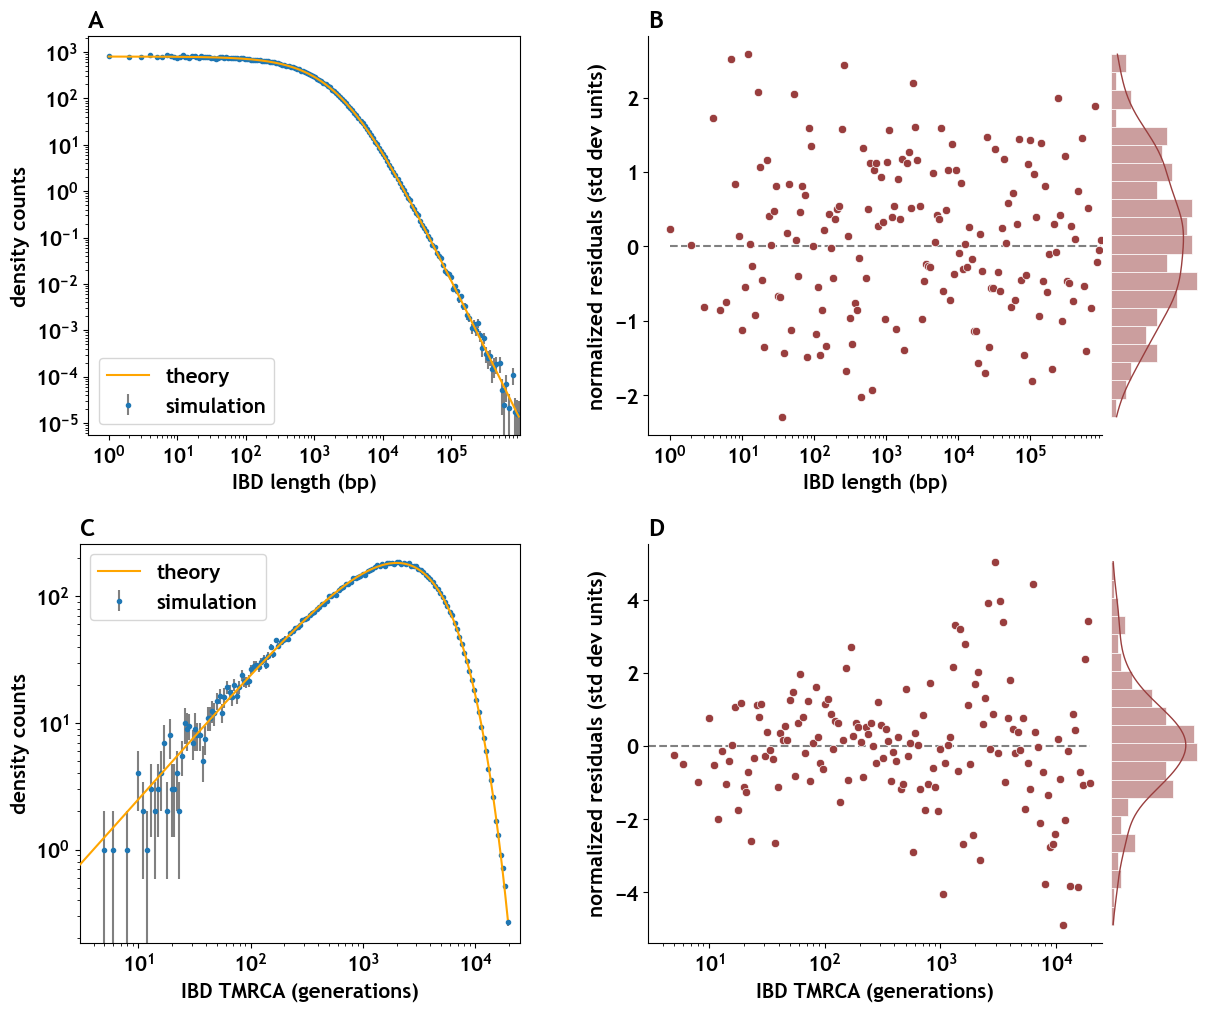

In [94]:
fig = figure(figsize=(12,10),layout="constrained")
subfigs = fig.subfigures(2,2,width_ratios=[1,1.2],height_ratios=[1,1],wspace=0.1,hspace=0.03)

axA = subfigs[1].subplots(1,1)
axA.errorbar(xk,yk,errk,fmt="o",markersize=3,ecolor="grey",label="simulation")
axA.plot(xk, yk_th, color="orange",label="theory", zorder=3)
axA.set_xscale("log")
axA.set_yscale("log")
axA.set_xlabel("IBD length (bp)")
axA.set_ylabel("density counts")
axA = setXrange(axA,1,1e6-1)
axA.legend()

axB, axC = subfigs[3].subplots(1,2,width_ratios=[1,0.2],gridspec_kw=Dict("wspace"=>0))
axB.plot([xk[1],xk[end]],[0,0], color="grey", linestyle="--")
scatterplot(x=xk_, y=yk_, color=(154/256,62/256,62/256), ax=axB, zorder=2)
axB.set_xscale("log")
axB.set_xlabel("IBD length (bp)")
axB.set_ylabel("normalized residuals (std dev units)")
axB.spines["right"].set_visible(false)
axB.spines["top"].set_visible(false)
axB = setXrange(axB,1,1e6-1)

histplot(y=yk_, color=(154/256,62/256,62/256), edgecolor="white", linewidth=0.5, alpha=0.5, ax=axC, bins=20, zorder=3, kde=true, 
    line_kws=Dict("linewidth"=>1,"zorder"=>4))
axC.axis("off")

axD = subfigs[2].subplots(1,1,width_ratios=[1])
axD.errorbar(xt,yt,errt,fmt="o",markersize=3,ecolor="grey",label="simulation")
axD.plot(xt, yt_th, color="orange",label="theory", zorder=3)
axD.set_xscale("log")
axD.set_yscale("log")
axD.set_xlabel("IBD TMRCA (generations)")
axD.set_ylabel("density counts")
axD = setXrange(axD,4,2.5e4)
axD.legend()

axE, axF = subfigs[4].subplots(1,2,width_ratios=[1,0.2],gridspec_kw=Dict("wspace"=>0))
axE.plot([xt[1],xt[end]],[0,0], color="grey", linestyle="--")
scatterplot(x=xt_, y=yt_, color=(154/256,62/256,62/256), ax=axE, zorder=2)
axE.set_xscale("log")
axE.set_xlabel("IBD TMRCA (generations)")
axE.set_ylabel("normalized residuals (std dev units)")
axE.spines["right"].set_visible(false)
axE.spines["top"].set_visible(false)
axE = setXrange(axE,4,2.5e4)

histplot(y=yt_, color=(154/256,62/256,62/256), edgecolor="white", linewidth=0.5, alpha=0.5, ax=axF, bins=20, zorder=3, kde=true, 
    line_kws=Dict("linewidth"=>1,"zorder"=>4))
axF.axis("off")

axA.set_title("A",loc="left")
axB.set_title("B",loc="left")
axD.set_title("C",loc="left")
axE.set_title("D",loc="left")

# savefig("stationary.pdf",bbox_inches="tight")

In [107]:
nfits = 4
Nupp = 30_000
Tlow = 5

fits = []
for i in 1:nfits
    if i == 1
        f = fit_epochs(h, ρ; nepochs = i)
    elseif i == 2
        f = fit_epochs(h, ρ; nepochs = i, Tlow = Tlow, Nupp = Nupp)
    else
        init = copy(fits[i-1].para)
        lastT = init[end - 1]
        lastN = init[end]
        nextT = i == 3 ? min(lastT/2, 1000) : min(lastT/2, 200)

        init[end-1] = lastT - nextT
        push!(init, nextT)
        push!(init, lastN)
        f = fit_epochs(h, ρ; init, nepochs = i, Tlow = Tlow, Tupp = 50_000, Nupp = Nupp)
    end
    push!(fits, f)
    println(f.opt.coeftable)
    println("log-evidence: ", f.opt.evidence)
end

init = [2.705646442602233e9, 858.734705102627]
─────────────────────────────────────────────────────────────────────────────
             Coef.  Std. Error        z  Pr(>|z|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────
TN[1]     2.1943e9   3.96851e6  552.927       0.0     2.18652e9     2.20208e9
TN[2]  1059.3        1.57002    674.707       0.0  1056.23       1062.38
─────────────────────────────────────────────────────────────────────────────
log-evidence: -5950.298041056563
init = [2.705646442602233e9, 858.734705102627, 1000.0, 858.734705102627]
───────────────────────────────────────────────────────────────────────────────
              Coef.  Std. Error         z  Pr(>|z|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────
TN[1]     2.81839e9   1.13543e7  248.222        0.0     2.79614e9     2.84065e9
TN[2]  1127.1         1.9411     580.65         0.0  1123.29    

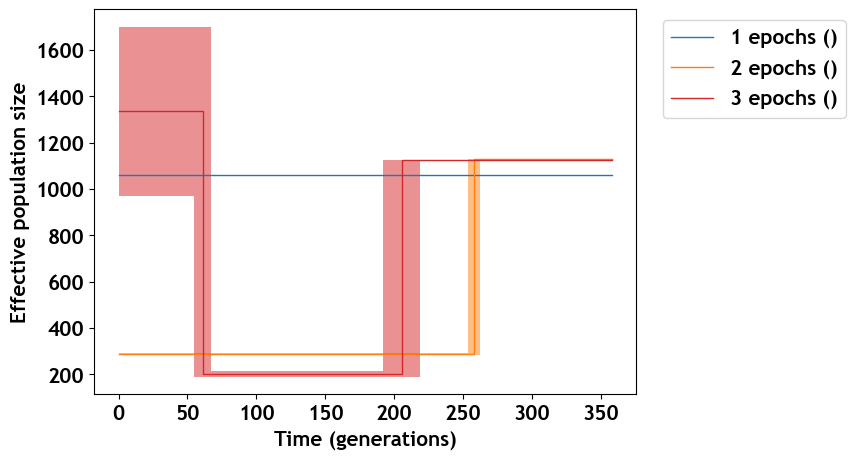

PyObject <matplotlib.legend.Legend object at 0x3fc165ba0>

In [109]:
_, ax = subplots(figsize=(7, 5))
mask = 1:3
plot_demography(mask, fits[mask], ax, tail=100, id="")

ax.set_xlabel("Time (generations)")
ax.set_ylabel("Effective population size")
legend(bbox_to_anchor=(1.03, 1), loc="upper left")

In [140]:
(fits[3].para[1] .- length(ibd)*TN[1]) ./ Vector(fits[3].opt.stderrors)[1]

0.4019356453628263

In [141]:
(fits[3].para[2:end] .- TN[2:end]) ./ Vector(fits[3].opt.stderrors)[2:end]

5-element Vector{Float64}:
  2.3280867002304166
  1.0145832752708774
  0.9982105210190966
 -1.2450591063465009
  0.7566833405139354

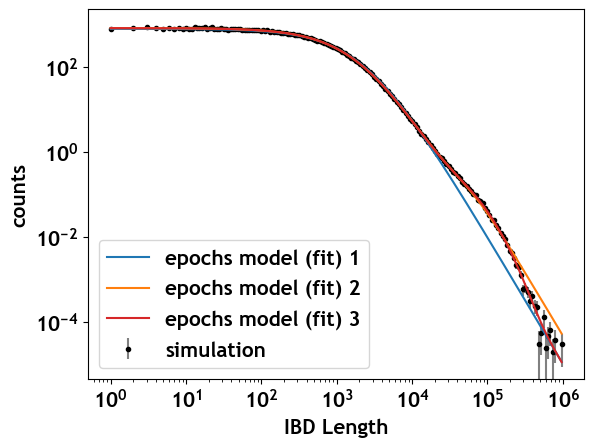

PyObject <matplotlib.legend.Legend object at 0x3fc825630>

In [119]:
errorbar(xk,yk,errk,fmt="o",markersize=3,color="black",ecolor="grey",label="simulation")

for f in fits[1:3]
    y_th = map(xk) do r 
        hid(f.para, ρ, r)
    end
    nepochs = Int(length(f.para)/2)
    c = "tab:" .* split("blue orange red purple olive brown cyan pink")[nepochs]
    plot(xk, y_th, color=c,label="epochs model (fit) $(f.nepochs)",zorder=2+nepochs,linewidth=1.5)
end

xscale("log")
yscale("log")
xlabel("IBD Length")
ylabel("counts")
legend()

## Evidence and posterior sampling

In [30]:
function nested_spl(hist, mu::Float64;
    nepochs::Int = 1,
    init = nothing,
    range_factor = 10,
    Tlow = 10, Tupp = 10000,
    Nlow = 10, Nupp = 100000,
    low = nothing, upp = nothing,
    level = 0.95
)

    obs_x = midpoints(hist.edges[1])
    obs_y = hist.weights
    obs_w = StatsBase.binvolume.(Ref(hist), 1:length(hist.edges[1])-1)

    function loglike(TN;
        counts = obs_y,
        weights = obs_w,
        mu = mu,
        r = obs_x)

        ll = mapreduce(+, eachindex(counts)) do i
            m = weights[i] * hid(TN, mu, r[i])
            if isnan(m)
                push!(ll, -Inf)
                return
            end
            logpdf(Poisson(m),counts[i])
        end
        return ll
    end

    if isnothing(init)
        Ltot = sum(obs_x .* obs_y)
        N = 1/(4*mu*(Ltot/sum(obs_y)))
        pinit = [Ltot, N]
        for i in 2:nepochs
            append!(pinit, [1000, N])
        end
    else
        pinit = copy(init)
        @assert length(pinit) == 2 * nepochs
    end

    if range_factor == 10
        low = [pinit[1]/range_factor, pinit[2]/range_factor]
        upp = [pinit[1]*range_factor, pinit[2]*range_factor]
        for i in 2:nepochs
            append!(low, [Tlow, Nlow])
            append!(upp, [Tupp, Nupp])
        end
    else
        low = []
        upp = []
        for i in 1:2*nepochs
            push!(low, pinit[i]-pinit[i]*range_factor)
            push!(upp, pinit[i]+pinit[i]*range_factor)
        end
    end
    TNd = Uniform.(low, upp)

    model = NestedModel(loglike, TNd)

    spl = Nested(2*nepochs, 10000; bounds=Bounds.NoBounds, proposal=Proposals.Slice())
    chain, state = sample(model, spl; dlogz=0.01)

    # chain_res = sample(chain, Weights(vec(chain["weights"])), length(chain));
    
    chain, state#, chain_res
end

nested_spl (generic function with 1 method)

In [31]:
chain, state = nested_spl(h1, μ; nepochs=4)

iter=7706	ncall=11483	Δlogz=2.3e+07	logl=-2.3e+07	logz=-2.3e+07

Excessive output truncated after 524341 bytes.

iter=7799	ncall=11682	Δlogz=2.2e+07	logl=-2.2e+07	logz=-2.2e+07

In [32]:
chain

Chains MCMC chain (663403×9×1 Array{Float64, 3}):

Log evidence      = -15764.561513352288
Iterations        = 1:1:663403
Number of chains  = 1
Samples per chain = 663403
parameters        = Parameter 1, Parameter 2, Parameter 3, Parameter 4, Parameter 5, Parameter 6, Parameter 7, Parameter 8
internals         = weights

Summary Statistics
   parameters              mean               std            mcse    ess_bulk  ⋯
       Symbol           Float64           Float64         Float64     Float64  ⋯

  Parameter 1   2625046429.3369   2201062001.2887   49642407.9699   4052.3817  ⋯
  Parameter 2        17513.4880         7208.3779        131.1149   2217.1556  ⋯
  Parameter 3         8245.8943         2833.4664         67.0985   1519.3612  ⋯
  Parameter 4        12647.3310        21450.5111        466.0065   2352.7136  ⋯
  Parameter 5         8506.9284         2632.9989         62.6088   1488.6714  ⋯
  Parameter 6        75346.5255        29111.7194        689.3607   1607.0536  ⋯
  Paramet

In [33]:
chain_res = sample(chain, Weights(vec(chain["weights"])), length(chain));

In [34]:
chain_res

Chains MCMC chain (663403×9×1 Array{Float64, 3}):

Iterations        = 1:663403
Number of chains  = 1
Samples per chain = 663403
parameters        = Parameter 1, Parameter 2, Parameter 3, Parameter 4, Parameter 5, Parameter 6, Parameter 7, Parameter 8
internals         = weights

Summary Statistics
   parameters              mean            std        mcse      ess_bulk       ⋯
       Symbol           Float64        Float64     Float64       Float64       ⋯

  Parameter 1   2344345943.1509   6850273.0360   8436.4263   658243.5692   661 ⋯
  Parameter 2        18503.0539        66.7923      0.0822   661744.4542   663 ⋯
  Parameter 3         9994.8023         4.6735      0.0057   663426.6199   663 ⋯
  Parameter 4         3918.9367        13.7728      0.0169   662718.9108   663 ⋯
  Parameter 5         9998.1103         1.8667      0.0023   661949.9636   659 ⋯
  Parameter 6        99678.2624       419.7602      0.5167   663438.8136   658 ⋯
  Parameter 7         4320.3838        56.5095     

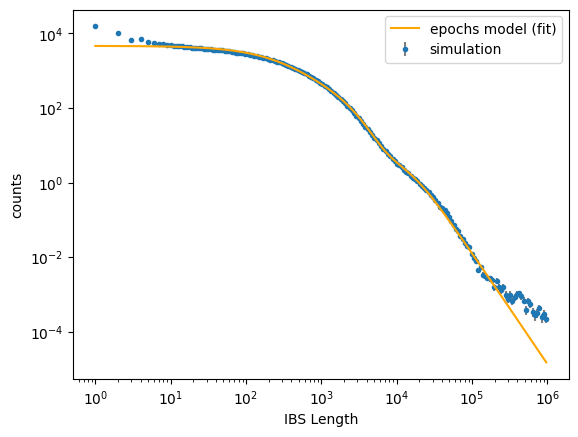

PyObject <matplotlib.legend.Legend object at 0x7fae2c967250>

In [47]:
errorbar(x,y,err,fmt="o",markersize=3,ecolor="grey",label="simulation")

y_th = map(x) do r 
    hid(mean(chain_res)[:,2], μ, r)
end
plot(x, y_th, color="orange",label="epochs model (fit)",zorder=3)

xscale("log")
yscale("log")
xlabel("IBS Length")
ylabel("counts")
legend()

In [80]:
function get_chains(hist, mu::Float64;
  nepochs::Int = 1,
  init = nothing,
  range_factor = 10,
  Tlow = 5, Tupp = 10000,
  Nlow = 5, Nupp = 100000,
  low = nothing, upp = nothing,
  level = 0.95
)

  obs_x = midpoints(hist.edges[1])
  obs_y = hist.weights
  obs_w = StatsBase.binvolume.(Ref(hist), 1:length(hist.edges[1])-1)

  if isnothing(init)
      Ltot = sum(obs_x .* obs_y)
      N = 1/(4*mu*(Ltot/sum(obs_y)))
      pinit = [Ltot, N]
      for i in 2:nepochs
          append!(pinit, [1000, N])
      end
  else
      pinit = copy(init)
      @assert length(pinit) == 2 * nepochs
  end

  if range_factor == 10
    low = [pinit[1]/range_factor, pinit[2]/range_factor]
    upp = [pinit[1]*range_factor, pinit[2]*range_factor]
    for i in 2:nepochs
        append!(low, [Tlow, Nlow])
        append!(upp, [Tupp, Nupp])
    end
  else
    low = []
    upp = []
    for i in 1:2*nepochs
        push!(low, pinit[i]-pinit[i]*range_factor)
        push!(upp, pinit[i]+pinit[i]*range_factor)
    end
  end
  TNd = Uniform.(low, upp)

  model = EpochModel.model_epochs(obs_x, obs_y, obs_w, mu, TNd)

  Random.seed!()
  burnin = 1000
  chainsamples = 20_000
  chain = sample(model, NUTS(burnin, 0.65), chainsamples, init_params = pinit)

  chain
end

get_chains (generic function with 1 method)

In [81]:
post_chain = get_chains(h1, μ; nepochs=4, init = f4_rep.para)

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:20:51


Chains MCMC chain (20000×20×1 Array{Float64, 3}):

Iterations        = 1001:1:21000
Number of chains  = 1
Samples per chain = 20000
Wall duration     = 1261.98 seconds
Compute duration  = 1261.98 seconds
parameters        = TN[1], TN[2], TN[3], TN[4], TN[5], TN[6], TN[7], TN[8]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters              mean             std           mcse     ess_bulk     ⋯
      Symbol           Float64         Float64        Float64      Float64     ⋯

       TN[1]   2763203643.1877   66732474.5901   1907098.3591    2372.9814     ⋯
       TN[2]        11346.6337         14.1776         0.1287   12146.3427   1 ⋯
       TN[3]         1266.3781        188.9996         5.1385    1752.1314     ⋯
       TN[4]         1881.3429        202.1742         5.3163    1911.1855     ⋯
       TN[

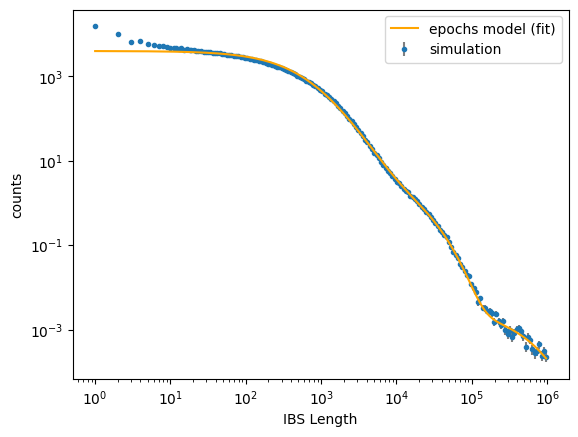

PyObject <matplotlib.legend.Legend object at 0x7f1670ee1ea0>

In [82]:
errorbar(x,y,err,fmt="o",markersize=3,ecolor="grey",label="simulation")

y_th = map(x) do r 
    hid(mean(post_chain)[:,2], μ, r)
end
plot(x, y_th, color="orange",label="epochs model (fit)",zorder=3)

xscale("log")
yscale("log")
xlabel("IBS Length")
ylabel("counts")
legend()

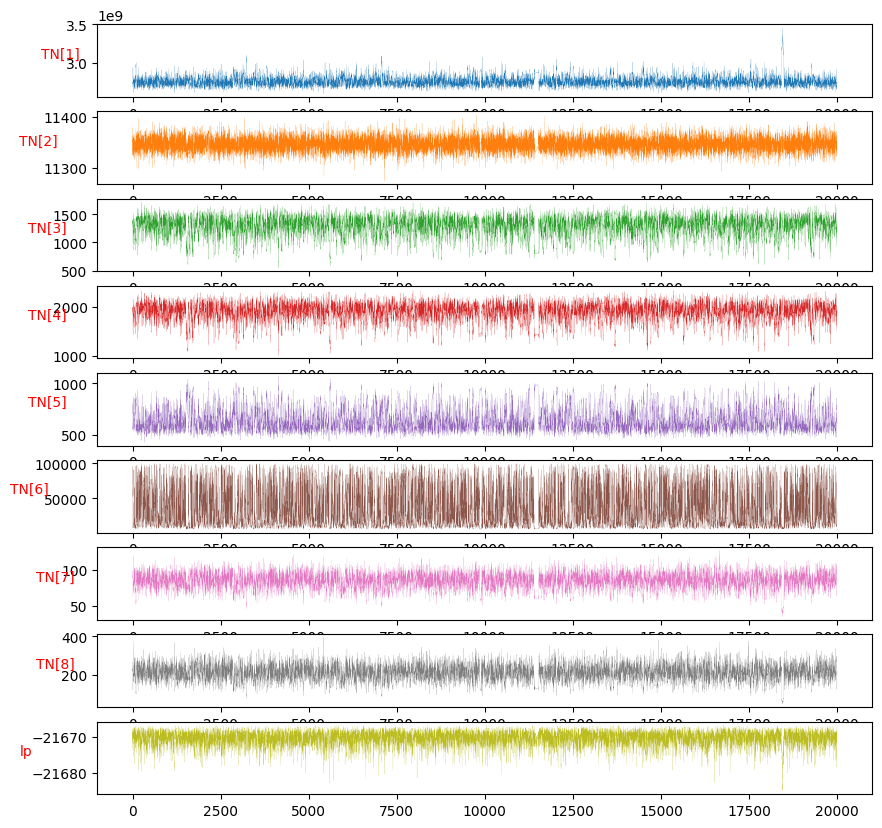

In [83]:
function plotchain(chain)
    c = chain
    labels = push!(string.(names(c, :parameters)), "lp")
    
    fig = figure()
    palette = "tab:" .* split("blue orange green red purple brown pink gray olive cyan");
    axs = fig.subplots(length(labels), 1)
    for (ax, p) in zip(axs, 1:length(labels))
        ax.plot(c[:,p,1], lw = 0.1, color = palette[p])
        isnothing(labels) || ax.set_ylabel(labels[p], rotation =0, color = "red")
    end
    fig.set_size_inches(10, 10)
    fig
end

plotchain(post_chain);

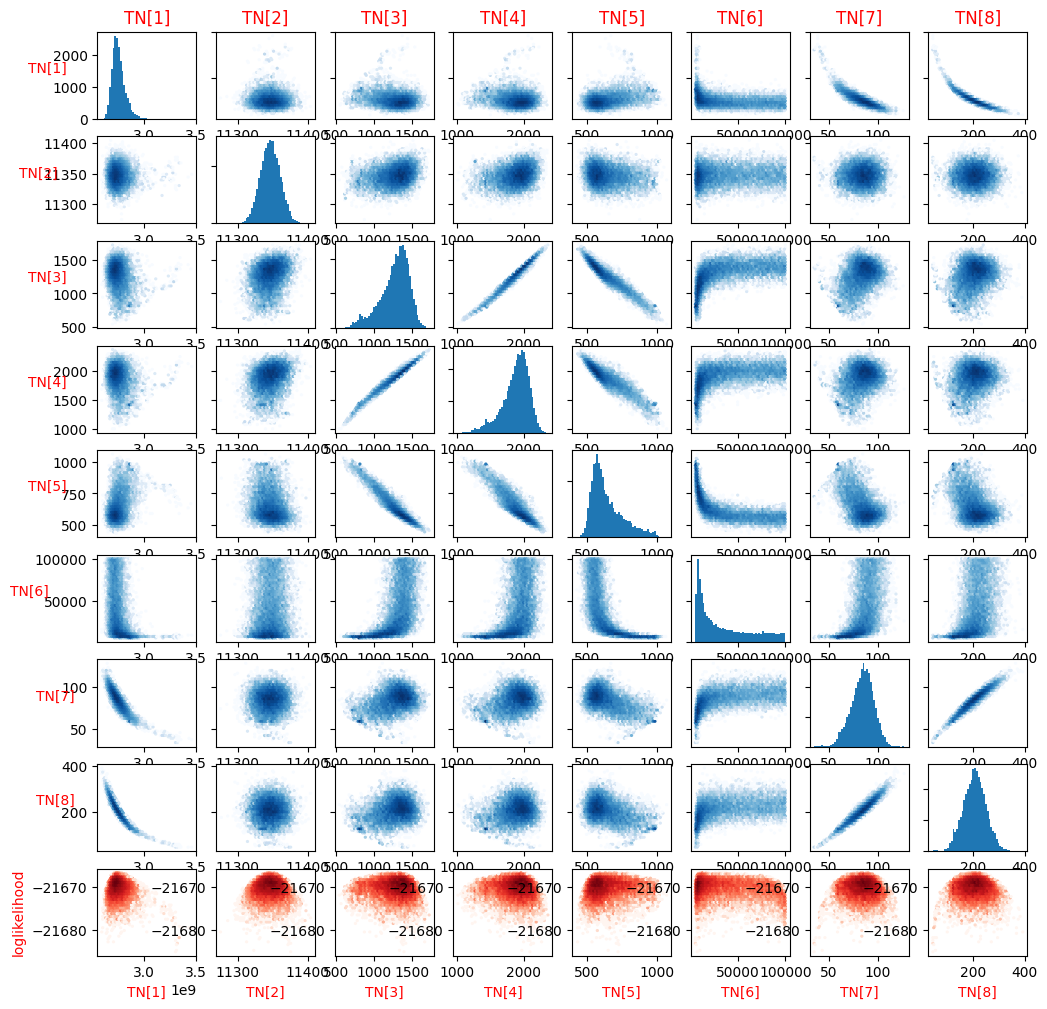

In [84]:
# using PyPlot, PyCall, Colors, PlotUtils, Dates, Printf

function plotchain2(chain)
    c = chain
    labels = push!(string.(names(c, :parameters)), "lp")
    
    palette = "tab:" .* split("blue orange green red purple brown pink gray olive cyan");
    npara = length(labels)-1

    vals = map(1:npara+1) do p
        c[:, p, 1]
    end
    
    fig = figure()
    axs = fig.subplots(npara+1, npara)
    for p1 in 1:npara, p2 in 1:npara
        if p1 == p2
            axs[p2,p1].hist(vals[p1], bins = 50)
        elseif p1 != p2
            axs[p2,p1].hexbin(vals[p1], vals[p2], gridsize=50, bins="log", cmap="Blues")
        end
        # axs[p2,p1].set_xticklabels("")
        p1 > 1 && axs[p2,p1].set_yticklabels("")
    end
    for p in 1:npara
        axs[npara+1, p].hexbin(vals[p], vals[npara+1], gridsize=50, bins="log", cmap="Reds")
    end
    
    isnothing(labels) || for p in 1:npara
        axs[1,p].set_title(labels[p], color = "red")
        axs[npara+1,p].set_xlabel(labels[p], rotation =0, color = "red")
        axs[p,1].set_ylabel(labels[p], rotation =0, color = "red")
    end
    axs[npara+1,1].set_ylabel("loglikelihood", color = "red")
    # axs[1,3].set_title("$(r.PopulationShort) ($(r.pop), N=$(r.N), id=$(r.id))")
    
    fig.set_size_inches(12, 12)
    fig
end

plotchain2(post_chain);

In [38]:
function hessian_mle(hist, mu, para)
    obs_x = midpoints(hist.edges[1])
    obs_y = hist.weights
    obs_w = StatsBase.binvolume.(Ref(hist), 1:length(hist.edges[1])-1)

    function loglike(TN;
        counts = obs_y,
        weights = obs_w,
        mu = mu,
        r = obs_x)

        ll = mapreduce(+, eachindex(counts)) do i
            m = weights[i] * hid(TN, mu, r[i])
            if isnan(m)
                push!(ll, -Inf)
                return
            end
            logpdf(Poisson(m),counts[i])
        end
        return ll
    end

    ForwardDiff.hessian(loglike, para)
end

hessian_mle (generic function with 1 method)

In [66]:
hessian_mle(h1, μ, mean(post_chain)[:,2])

-9.785010665553116e-21